# Results analysis
**Last update: 2021-01-06**
* Experiment: Instructing Robots a Dance Sequence
* Course: Human-Robot Interaction
* Author: Emma Vriezen (s1010487)

First half of this Notebook is the statistical analysis of the quantitative part of the experiment, i.e. the real 'experiment'. The second half is the analysis of the qualitative part, i.e. the questionnaire.

In [1]:
# Imports:
import glob  # To loop t files
import os  # To find the current working directory
import ast # Strings to lists
import math  # To check for NaNs
import pandas as pd  # For DataFrame
import numpy as np  # For its arrays
import matplotlib.pyplot as plt  # For plots
import scipy.stats as sts  # For statistics
from matplotlib.ticker import MaxNLocator  # For forcing labels to be an integer


## Quantitative analysis
In the experiment, participants used two interfaces: gestural and vocal.

We will look at whether there is a significant difference between these aspects of the interfaces:
* The average number of mistakes per trial
* The average duration of a trial

In [2]:
# Read in data and convert labels to vector:
path = os.path.join(os.getcwd(), "responses")
all_files = glob.glob(os.path.join(path, "*.csv"))
df = pd.concat((pd.read_csv(f, index_col=None) for f in all_files))
df.reset_index(drop=True, inplace=True)  # Drop the original index
print(df.head())
print(df.tail())
print("Input data shape:", df.shape)


   LL_AttemptsForProgress_0  LL_AttemptsForProgress_1  \
0                       3.0                       1.0   
1                       1.0                       1.0   
2                       8.0                       1.0   
3                       NaN                       NaN   
4                       NaN                       NaN   

   LL_AttemptsForProgress_2  LL_AttemptsForProgress_3  \
0                       2.0                       2.0   
1                       1.0                       1.0   
2                       1.0                       1.0   
3                       NaN                       NaN   
4                       NaN                       NaN   

                   LL_CorrectKeyword                LL_DetectedCommands  \
0           [0, 0, 1, 1, 0, 1, 0, 1]           [2, 2, 0, 1, 1, 2, 0, 3]   
1                       [1, 1, 1, 1]                       [4, 5, 2, 3]   
2  [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1]  [2, 1, 2, 1, 2, 1, 3, 0, 1, 4, 5]   
3             

C:\Users\emmav\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  after removing the cwd from sys.path.


In [3]:
# The practice trials were recorded by accident and should not be regarded at all.
# So, remove all of them:
df = df[df.practice == "no"]


In [4]:
# Next, remove all the columns with only one unique value, since these do not contain useful information:
only_LL = df

for col in df.columns:
    # Our custom columns start with 'LL_', and we want to keep three other useful columns:
    if not col.startswith("LL_") and col != "subject_nr" and col != "order" and col != "interface":
        only_LL = only_LL.drop(col, axis=1)
only_LL.reset_index(drop=True, inplace=True)


In [5]:
# Inspect the columns that remain:
print(only_LL.columns)


Index(['LL_AttemptsForProgress_0', 'LL_AttemptsForProgress_1',
       'LL_AttemptsForProgress_2', 'LL_AttemptsForProgress_3',
       'LL_CorrectKeyword', 'LL_DetectedCommands', 'LL_ProgressTrialFailedAt',
       'LL_TimeITIEnd', 'LL_TimeITIStart', 'LL_TimeKeywordDetection',
       'LL_TimeStartListening', 'LL_TimeStopListening', 'LL_TimeTrialEnd',
       'LL_TimeTrialStart', 'LL_TrialStatus', 'interface', 'order',
       'subject_nr'],
      dtype='object')


In [6]:
# Fix the NaNs in the 'LL_AttemptsForProgress_X' with X out of [0,3].
# The value that should be instead of a NaN can be deduced from 'LL_CorrectKeyword'.
for i, correct_keyword in enumerate(only_LL["LL_CorrectKeyword"]):
    correct_keyword_list = ast.literal_eval(correct_keyword)  # Extract list from string
    
    attempt = 0  # Attempts so far by the participant to successfully do a command
    counter = 0  # Of the so-called Progress; the x-th command in the target sequence
    
    for correct in correct_keyword_list:
        assert counter < 4
        attempt += 1
        if correct == 1:
            only_LL.loc[i, "LL_AttemptsForProgress_" + str(counter)] = attempt
            counter += 1
            attempt = 0
    
    # Usually not all four progresses have been done in a failed trial, so fix those here:
    while counter < 4:
        if math.isnan(only_LL.loc[i, "LL_AttemptsForProgress_" + str(counter)]):
            only_LL.loc[i, "LL_AttemptsForProgress_" + str(counter)] = attempt
        counter += 1
        attempt = 0


In [7]:
# Add the amount of made mistakes per trial and whether a trial was a mistake or not:
only_LL['mistakes'] = [x.count('0') for x in only_LL['LL_CorrectKeyword']]
only_LL['timeout'] = [int(x.count('1') < 4) for x in only_LL['LL_CorrectKeyword']]

# Add the average time of a trial:
only_LL['trialtime'] = only_LL['LL_TimeTrialEnd'] - only_LL['LL_TimeTrialStart']


In [8]:
# Have a look at the table so far:
only_LL


,LL_AttemptsForProgress_0,LL_AttemptsForProgress_1,LL_AttemptsForProgress_2,LL_AttemptsForProgress_3,LL_CorrectKeyword,LL_DetectedCommands,LL_ProgressTrialFailedAt,LL_TimeITIEnd,LL_TimeITIStart,LL_TimeKeywordDetection,...,LL_TimeStopListening,LL_TimeTrialEnd,LL_TimeTrialStart,LL_TrialStatus,interface,order,subject_nr,mistakes,timeout,trialtime
0,0.0,0.0,0.0,0.0,[],[],NaN,1.609196e+09,1.609196e+09,[],...,[1609195520.0234573],1.609196e+09,1.609196e+09,success,gestural,"[0, 3, 2, 1]",0,0,1,6.313448
1,0.0,0.0,0.0,0.0,[],[],NaN,1.609196e+09,1.609196e+09,[],...,[1609195529.5819032],1.609196e+09,1.609196e+09,success,gestural,"[3, 1, 0, 5]",0,0,1,6.280429
2,0.0,0.0,0.0,0.0,[],[],NaN,1.609196e+09,1.609196e+09,[],...,[1609195539.0514784],1.609196e+09,1.609196e+09,success,gestural,"[5, 3, 0, 4]",0,0,1,6.220936
3,1.0,0.0,0.0,0.0,[0],[2],NaN,1.609196e+09,1.609196e+09,[1609195547.0030756],...,"[1609195547.0030756, 1609195560.9101777]",1.609196e+09,1.609196e+09,success,gestural,"[0, 3, 4, 2]",0,1,1,18.550494
4,1.0,1.0,1.0,1.0,"[1, 1, 1, 1]","[5, 1, 2, 3]",NaN,1.609196e+09,1.609196e+09,"[1609195569.2287478, 1609195581.9229696, 16091...",...,"[1609195569.2287478, 1609195581.9229696, 16091...",1.609196e+09,1.609196e+09,success,gestural,"[5, 1, 2, 3]",0,0,0,55.358724
5,1.0,2.0,1.0,1.0,"[1, 0, 1, 1, 1]","[3, 1, 0, 4, 2]",NaN,1.609196e+09,1.609196e+09,"[1609195627.9256763, 1609195640.3439653, 16091...",...,"[1609195627.9256763, 1609195640.3439653, 16091...",1.609196e+09,1.609196e+09,success,gestural,"[3, 0, 4, 2]",0,1,0,63.068013
6,1.0,1.0,1.0,1.0,"[1, 1, 1, 1]","[3, 1, 0, 5]",NaN,1.609196e+09,1.609196e+09,"[1609195916.2044234, 1609195927.1323252, 16091...",...,"[1609195916.2044234, 1609195927.131322, 160919...",1.609196e+09,1.609196e+09,success,vocal,"[3, 1, 0, 5]",0,0,0,44.791136
7,1.0,1.0,0.0,0.0,"[1, 1]","[3, 4]",NaN,1.609196e+09,1.609196e+09,"[1609195964.3211377, 1609195975.4454372]",...,"[1609195964.3211377, 1609195975.4444318, 16091...",1.609196e+09,1.609196e+09,success,vocal,"[3, 4, 2, 1]",0,0,1,29.132409
8,1.0,1.0,1.0,0.0,"[1, 1, 1]","[4, 1, 0]",NaN,1.609196e+09,1.609196e+09,"[1609195996.8739624, 1609196007.6801827, 16091...",...,"[1609195996.8729632, 1609196007.6801827, 16091...",1.609196e+09,1.609196e+09,success,vocal,"[4, 1, 0, 2]",0,0,1,40.205936
9,0.0,0.0,0.0,0.0,[],[],NaN,1.609196e+09,1.609196e+09,[],...,[1609196043.813244],1.609196e+09,1.609196e+09,success,vocal,"[0, 2, 3, 5]",0,0,1,6.362897


In [9]:
# Get the average of the interesting variables per participant, per interface:
mean_mistakes = only_LL.groupby(['subject_nr', 'interface']).mean()['mistakes']
mean_trialtime = only_LL.groupby(['subject_nr', 'interface', 'timeout']).mean()['trialtime']
# Only keep avg. trial time for successful trials:
mean_succes_trialtime = mean_trialtime[:,:,0]


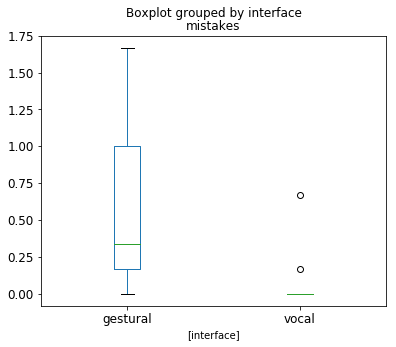

Ttest_relResult(statistic=3.6253078686998625, pvalue=0.0022743074543172446)


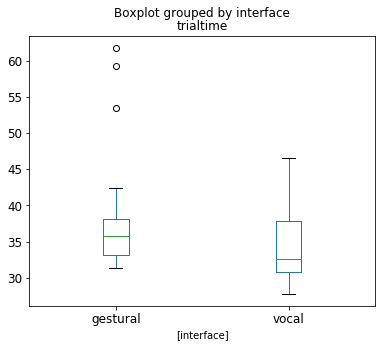

Ttest_relResult(statistic=2.775962808238544, pvalue=0.013493613486890474)


In [10]:
# Make plots and calculate significance with a dependent t-test:
mean_mistakes.to_frame().boxplot(by='interface', grid=False, figsize=(6,5), fontsize=12)
plt.show()
print(sts.ttest_rel(list(mean_mistakes[:,'gestural']), list(mean_mistakes[:,'vocal'])))
mean_succes_trialtime.to_frame().boxplot(by='interface', grid=False, figsize=(6,5), fontsize=12)
plt.show()
print(sts.ttest_rel(list(mean_succes_trialtime[:,'gestural']), list(mean_succes_trialtime[:,'vocal'])))


## Qualitative analysis
The experiment concludes with a questionnaire where the subjects are asked about their experience with the two interfaces.

We will look at whether there is a significant difference between these aspects of the interfaces:
* The perceived efficiency
* The experienced joy while using the interface
* The experienced anxiety while using the interface

In [11]:
# Read in data, look at the columns for later indexing and display DataFrame for inspection:
path = "QuestionnaireResults.csv"
df = pd.read_csv(path, index_col=None)
column_names = df.columns
for col_i, column_name in enumerate(column_names):
    print(str(col_i) + ':', column_name)
print(df.head())
print("Input data shape:", df.shape)


0: Tijdstempel
1: Participant number (integer):
2: How old are you?
3: What is your gender? 
4: Do you have experience with other experiments or games that are similar to the current experiment? If yes, describe your experience below.
5: I felt confident enough to use the gestural interface after the practice trials with the gestures.
6: I felt confident enough to use the vocal interface after the practice trials with the voice commands.
7: Where there any specific moves from the Nao you found particularly challenging for one or both interfaces? Explain below.
8: The gesture control was practical for controlling the Nao.
9: The voice control was practical for controlling the Nao.
10: With the voice control I was able to make the Nao perform the dance tasks rapidly.
11: With the gesture control I was able to make the Nao perform the dance tasks rapidly.
12: The voice control interface is easy to use.
13: The gesture control interface is easy to use.
14: It was easy to learn to use the v

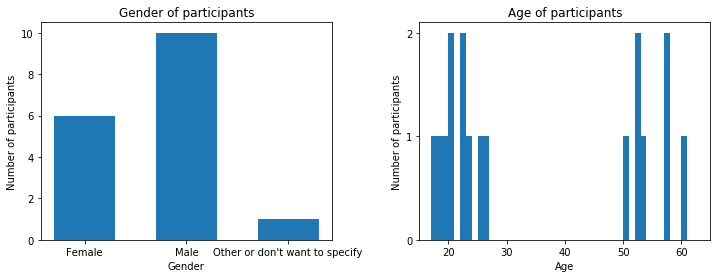

In [12]:
# Let's look at the age and gender of our participants:
bins, counts = np.unique(df.iloc[:,3].values, return_counts=True)

# Subplots:
fig, (gender_ax, age_ax) = plt.subplots(1, 2, figsize=(12, 4))

# Gender:
gender_bars = gender_ax.bar(x=bins, height=counts, width=0.6)
gender_ax.set_ylabel('Number of participants')
gender_ax.set_xlabel('Gender')
gender_ax.set_title('Gender of participants')

# Age:
ages, _ = np.unique(df.iloc[:,2].values, return_counts=True)
bin_count = ages.max() - ages.min()

df.hist(column=[column_names[2]], grid=False, ax=age_ax, bins=bin_count)
age_ax.set_ylabel('Number of participants')
age_ax.set_xlabel('Age')
age_ax.set_title('Age of participants')
age_ax.yaxis.set_major_locator(MaxNLocator(integer=True))
age_ax.set_xlim(15, 65)

plt.show()

Now, we will look at thow the answers on the questions about the interfaces are different.
A simple sign test can be used, because the data are paired, but are also ordinal and non-parametric.
However, the *likert scale can be interpreted as interval data*. Then the **wilcoxon signed-rank test** can be used instead.
The method of dealing with zero differences as described by Pratt is better for ordinal data, and is hence used here too.

In [13]:
# Replace all ordinal ranks with integers:
ranks = {'Entirely disagree': 1, 'Mostly disagree': 2, 'Somewhat disagree': 3,
         'Neither agree or disagree': 4, 'Somewhat agree': 5, 'Mostly agree': 6, 'Entirely agree': 7}

df.replace(to_replace=ranks, value=None, inplace=True)
df.head(1)


,Tijdstempel,Participant number (integer):,How old are you?,What is your gender?,"Do you have experience with other experiments or games that are similar to the current experiment? If yes, describe your experience below.",I felt confident enough to use the gestural interface after the practice trials with the gestures.,I felt confident enough to use the vocal interface after the practice trials with the voice commands.,Where there any specific moves from the Nao you found particularly challenging for one or both interfaces? Explain below.,The gesture control was practical for controlling the Nao.,The voice control was practical for controlling the Nao.,...,The voice control interface is easy to use.,The gesture control interface is easy to use.,It was easy to learn to use the voice control interface to make the Nao dance.,It was easy to learn to use the gesture control interface to make the Nao dance.,Which method did you find the most difficult to work with?,I like using the voice control interface for instructing the Nao to dance.,I like using the gesture control interface for instructing the Nao to dance.,I feel anxious using the voice control interface for instructing the Nao to dance.,I feel anxious using the gesture control interface for instructing the Nao to dance.,Which method felt the most natural to you ?
0,2020/12/26 2:38:00 p.m. CET,20,22,Male,"I have some experience with programming, compu...",6,6,"""Raise the roof"" was a bit hard to pronounce f...",6,5,...,6,5,7,6,Similarly for both voice and gesture interfaces,4,4,3,4,Mostly the voice interface


In [14]:
# Next, compare the level of confidence between the two interfaces.
# Order does not matter for H0 = two-sided, but here x is always gestural, and y is vocal.
comparisons = {"confidence": sts.wilcoxon(x=df.iloc[:,5], y=df.iloc[:,6], zero_method='pratt'),
               "practical": sts.wilcoxon(x=df.iloc[:,8], y=df.iloc[:,9], zero_method='pratt'),
               "rapid": sts.wilcoxon(x=df.iloc[:,11], y=df.iloc[:,10], zero_method='pratt'),
               "easy_use": sts.wilcoxon(x=df.iloc[:,13], y=df.iloc[:,12], zero_method='pratt'),
               "easy_learn": sts.wilcoxon(x=df.iloc[:,15], y=df.iloc[:,14], zero_method='pratt'),
               "like": sts.wilcoxon(x=df.iloc[:,18], y=df.iloc[:,17], zero_method='pratt'),
               "anxious": sts.wilcoxon(x=df.iloc[:,20], y=df.iloc[:,19], zero_method='pratt')
              }

print(comparisons)


{'confidence': WilcoxonResult(statistic=15.0, pvalue=0.003580595343696838), 'practical': WilcoxonResult(statistic=53.5, pvalue=0.2698535341858619), 'rapid': WilcoxonResult(statistic=63.0, pvalue=0.5199024076551297), 'easy_use': WilcoxonResult(statistic=49.0, pvalue=0.18935034307365872), 'easy_learn': WilcoxonResult(statistic=41.0, pvalue=0.09024981810521199), 'like': WilcoxonResult(statistic=45.5, pvalue=0.1402295325354059), 'anxious': WilcoxonResult(statistic=43.5, pvalue=0.11768381777421799)}


Two other questions had a different format, where the answers were on a scale between the two interfaces. These answers can be analysed by looking at bar charts and the median. The columns of the questions are 16 and 21.

In [15]:
# Replace all ordinal ranks with integers:
ranks = {'Entirely the gesture interface': 1, 'Mostly the gesture interface': 2, 'Somewhat the gesture interface': 3,
         'Similarly for both voice and gesture interfaces': 4, 'Somewhat the voice interface': 5,
         'Mostly the voice interface': 6, 'Entirely the voice interface': 7}

df.replace(to_replace=ranks, value=None, inplace=True)


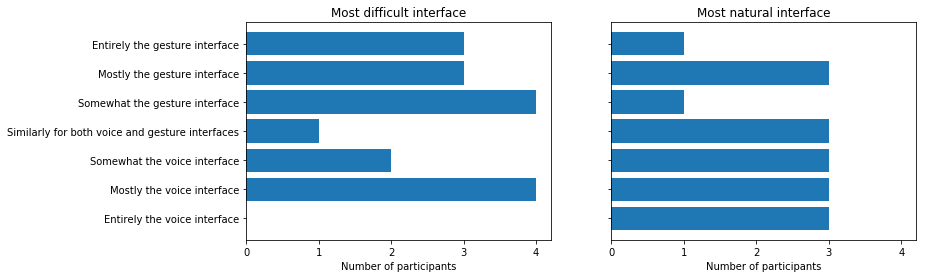

Medians for...
... difficulty: 3.0 or Somewhat the gesture interface
... natural: 5.0 or Somewhat the voice interface


In [22]:
# Make horizontal bar plots of the answers.
# Subplots and labels:
fig, (dif_ax, nat_ax) = plt.subplots(1, 2, figsize=(12, 4), sharey=True, sharex=True)
labels = list(ranks.keys())

# Count the number of answers for each point on the scale:
answers_dif = []
answers_nat = []
for answer in range(1,8):
    answers_dif.append(df.loc[df.iloc[:,16] == answer, column_names[16]].count())
    answers_nat.append(df.loc[df.iloc[:,21] == answer, column_names[21]].count())

# Plot 'Which is the most difficult interface?':
dif_ax.barh(labels, answers_dif)
dif_ax.invert_yaxis()  # To have the same order as everywhere else, gesture - voice.
dif_ax.set_xlabel('Number of participants')
dif_ax.set_title('Most difficult interface')
dif_ax.xaxis.set_major_locator(MaxNLocator(integer=True))

# Plot 'Which interface feels most natural?':
nat_ax.barh(labels, answers_nat)
nat_ax.set_xlabel('Number of participants')
nat_ax.set_title('Most natural interface')

plt.show()

print("Medians for...")
dif_median = np.median(df.iloc[:,16])
nat_median = np.median(df.iloc[:,21])
print("... difficulty:", dif_median, "or", list(ranks.keys())[list(ranks.values()).index(dif_median)])
print("... natural:", nat_median, "or", list(ranks.keys())[list(ranks.values()).index(nat_median)])
